In [19]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from functions import pendulum_motion, numerical_derivative
import time

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.manual_seed(42)
model = FCN(1,1,100,5)

# Initial and boundary conditions

The domain of the problem is

$t\in[0,t_{final}]$

I'm not hard coding t_final to see if I can get an answer for arbitrary t_finals.

The differential equation is 

$\ddot{\theta} + \frac{g}{R}\sin(\theta) + \beta \dot{\theta}$ = 0

And general initial position and velocity 

$\theta(0) = \theta_0$

$\dot{\theta}(0) = \dot{\theta}_0$

In [20]:
t_final = 3
g = 9.81
R = 0.2
beta = 0

# For initial condition loss
dt = 1e-8
theta_dot_0 = 0
theta_0 = 0.6 #0.3

theta_initial = [theta_0, theta_0]
theta_initial = torch.tensor(theta_initial).view(-1,1)

theta_dot_initial = [theta_dot_0, theta_dot_0]
theta_dot_initial = torch.tensor(theta_dot_initial).view(-1,1)

t_initial = torch.tensor([0.0, 0.0]).requires_grad_(True).view(-1,1)

# Physics informed points
n = 200 # collation points
t = torch.linspace(0,t_final,n).view(-1,1).requires_grad_(True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10000

loss_history = [[],[]] # Epoch, loss
pbar = tqdm(total=n_epochs, desc="Initializing")

# For testing purpose, I want to have a list storing where the worst physics loss occurs
t_worst = []
sigma0 = 0.1
sigmaf = 1.4
sigma = sigma0
d_sigma = (sigmaf - sigma0)/(n_epochs)

for i in range(n_epochs):

    optimizer.zero_grad()
    
    # Initial condition loss
    theta_0_model = model(t_initial)
    loss_i = torch.mean((theta_initial - theta_0_model) ** 2)

    theta_t_0 = torch.autograd.grad(theta_0_model, t_initial, torch.ones_like(theta_0_model), create_graph=True)[0]
    loss_i += torch.mean((theta_dot_0 - theta_t_0) ** 2)

    # Physics-informed loss
    
    theta = model(t)
    theta_t = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
    theta_tt = torch.autograd.grad(theta_t, t, torch.ones_like(theta_t), create_graph=True)[0]
    loss_physics = torch.mean( (theta_tt + (g/R)*torch.sin(theta) + beta*theta_t)**2 )

    # t_max_loss = t[torch.argmax(loss_physics)].item()
    # t_worst.append(t_max_loss)
    # t = [min(abs(random.normalvariate(t_max_loss, t_final/50)),t_final) for _ in range(n)]
    # t = torch.tensor(t).view(-1,1).requires_grad_(True)

    t = [abs(random.normalvariate(0, sigma)) for _ in range(n)]
    t = torch.tensor(t).view(-1,1).requires_grad_(True)
    sigma += d_sigma
    if sigma >= sigmaf:
        sigma = sigma0
    
    # Backpropagate joint loss

    p1 = 1000

    p2 = np.sin(i/100)**2
    loss = loss_i*p1 + loss_physics*p2

    loss.backward(retain_graph=True)
    optimizer.step()

    loss_history[0].append(loss.detach().numpy())
    loss_history[1].append(i)
    pbar.set_description(f'Epoch {i + 1}/{n_epochs}, Loss IC: {loss_i.item():.8f}, Loss Phys: {loss_physics.item():.8f}')
    
    #pbar.set_description(f'Epoch {i + 1}/{n_epochs}, Loss IC: {loss_i.item():.8f}, Loss BC: {loss_b.item():.8f}, Loss Phys: {loss_physics.item():.8f}, Loss Stat.: {stat_loss.item():.8f}')
    pbar.update(1)
pbar.close()

Epoch 3/10000, Loss IC: 0.04085859, Loss Phys: 360.82391357:   0%|          | 2/10000 [00:00<04:04, 40.95it/s]

Epoch 10000/10000, Loss IC: 0.00004720, Loss Phys: 4.32082701: 100%|██████████| 10000/10000 [02:49<00:00, 58.98it/s]


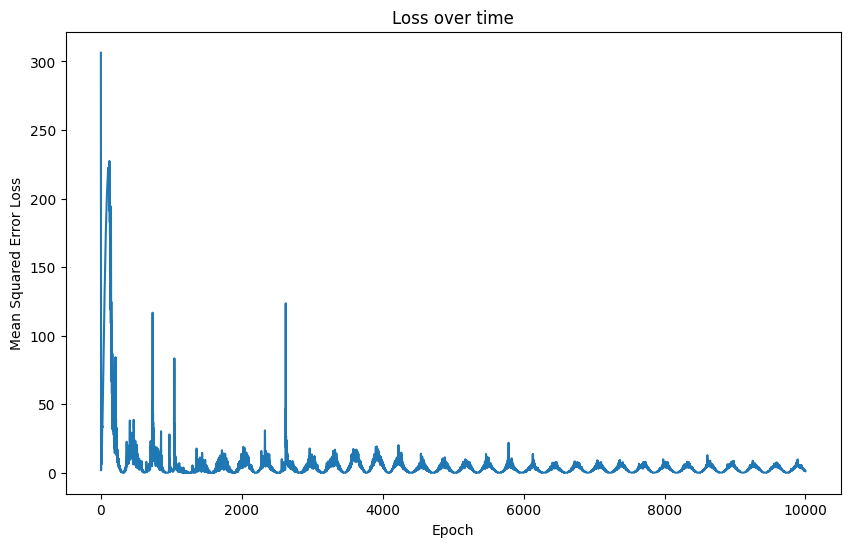

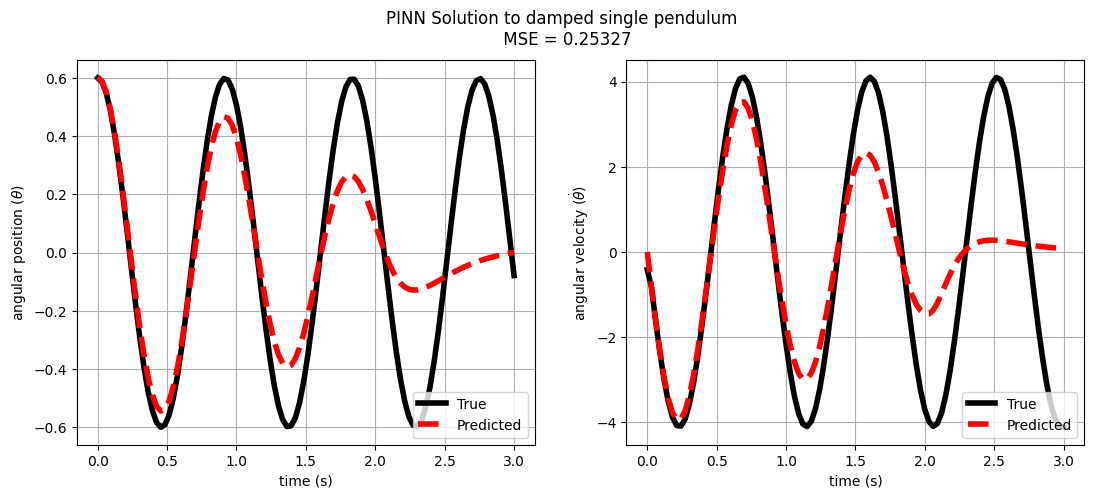

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history[1], loss_history[0])
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss over time')
plt.show()
lw = 4

t_numerical, theta_numerical = pendulum_motion(t_final, theta_0, theta_dot_0, g=g, R=R, damping_coefficient=beta, num_points=100)
t_dot_numerical, theta_dot_numerical = numerical_derivative(t_numerical,theta_numerical)

t = torch.tensor(t_numerical, dtype=torch.float32).view(-1,1)
t.requires_grad=True

u = model(t)
u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(t_numerical, theta_numerical, 'k', linewidth=lw)
plt.plot(t.detach().numpy(), u.detach().numpy(), 'r--', linewidth=lw)
plt.xlabel('time (s)')
plt.ylabel(r'angular position ($\theta$)')
plt.grid(True)
plt.legend(['True', 'Predicted'])

MSE = torch.mean( (torch.tensor(theta_numerical) - u)**2 )

MSE_str = '{:.5f}'.format(MSE.item())
plt.suptitle('PINN Solution to damped single pendulum \n MSE = ' + MSE_str)

plt.subplot(1,2,2)
plt.plot(t_dot_numerical, theta_dot_numerical, 'k', linewidth=lw)
plt.plot(t.detach().numpy(), u_t.detach().numpy(), 'r--', linewidth=lw)
plt.xlabel('time (s)')
plt.ylabel(r'angular velocity ($\dot{\theta}$)')
plt.grid(True)
plt.legend(['True', 'Predicted'])
plt.show()

In [22]:
# from functions import animate_pendulum_to_gif, combine_gifs
# frames_numerical = animate_pendulum_to_gif(t_numerical, theta_numerical, radius=R)
# frames_pinn = animate_pendulum_to_gif(t_numerical, u, radius=R)

# combine_gifs(frames_numerical, frames_pinn, total_time=t_final*1000, filename='combined_pendulum_animation.gif')

In [23]:
# plt.plot(t_worst)

In [24]:
# Convert the notebook to a script
# from functions import notebook_to_script
# notebook_to_script('pendulum_pinn.ipynb', 'pendulum_pinn.py')